In [3]:
from fastai.collab import *
# указыаем пуь
path = Path('')
print(path.ls())
# загрузка рейтинговых данных
ratings = pd.read_csv(path/'ratings.csv')
print(ratings.head())
# загрузка информационных данных
books = pd.read_csv(path/'books.csv')
print(books.head())

[PosixPath('.config'), PosixPath('ratings.csv'), PosixPath('books.csv'), PosixPath('sample_book.xml'), PosixPath('book_tags.csv'), PosixPath('to_read.csv'), PosixPath('tags.csv'), PosixPath('sample_data')]
   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4
   id  ...                                    small_image_url
0   1  ...  https://images.gr-assets.com/books/1447303603s...
1   2  ...  https://images.gr-assets.com/books/1474154022s...
2   3  ...  https://images.gr-assets.com/books/1361039443s...
3   4  ...  https://images.gr-assets.com/books/1361975680s...
4   5  ...  https://images.gr-assets.com/books/1490528560s...

[5 rows x 23 columns]


In [4]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [5]:
data.show_batch()

user_id,book_id,target
14922,3635,5.0
22380,7442,4.0
21378,9890,5.0
27128,1440,5.0
20586,279,3.0


In [6]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

Модель EmbeddingDotBias

In [ ]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1)

График скорости обучения

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


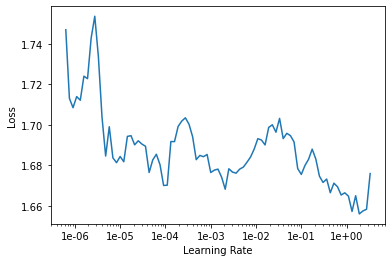

In [ ]:
learn.lr_find() # нахождение скорости обучения
learn.recorder.plot() # построение графика скорости обучения

In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.585281,1.589317,10:29
1,1.328047,1.317406,14:19
2,1.099069,1.133964,13:45
3,1.057179,1.069734,13:09
4,1.026205,1.060190,12:28


In [ ]:
learn.save('goodbooks-dot-1')

Модель EmbeddingNN

In [7]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

График скорости обучения

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


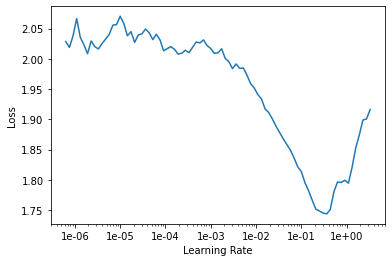

In [8]:
learn.lr_find() # нахождение скорости обучения
learn.recorder.plot() # построение графика скорости обучения

In [9]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.761117,0.768703,11:35
1,0.743896,0.739517,15:57
2,0.715355,0.722845,15:57
3,0.690373,0.705697,15:05
4,0.597041,0.717636,14:12


Интерпретация

In [ ]:
# загрузка моедли EmbeddingDotBias
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');
# получение лучших книг
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
# создание массива, содержащего названия лучших книг 
top_books_with_name = []
for book in top_books:
  top_books_with_name.append(books[(books['id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)

In [ ]:
# получение предвзятость для лучших книг 
book_bias = learn.bias(top_books, is_item=True)
# получение средних оценок
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]
# информация о предвзятости печатной книги 
item0 = lambda o:o[0]
print(sorted(book_ratings, key=item0)[:15])
print(sorted(book_ratings, key=item0, reverse=True)[:15])
# получение веса
book_w = learn.weight(top_books, is_item=True)
# преобразование веса в 3 измерения 
book_pca = book_w.pca(3)
# получение основных компонентов
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]
# вывод информации fac0
print(sorted(book_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(book_comp, key=itemgetter(0))[:10])
# вывод информации fac1
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]
print(sorted(book_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(book_comp, key=itemgetter(0))[:10])

[(tensor(-0.0984), 'The Almost Moon', 2.49), (tensor(-0.0361), 'Skinny Bitch', 2.9), (tensor(-0.0352), 'Bergdorf Blondes', 3.0), (tensor(-0.0337), 'The Particular Sadness of Lemon Cake', 2.93), (tensor(-0.0125), 'The Weird Sisters', 3.08), (tensor(-0.0111), 'Nightfall (The Vampire Diaries: The Return, #1)', 3.12), (tensor(-0.0056), 'Swamplandia!', 3.02), (tensor(0.0029), 'Need (Need, #1)', 3.22), (tensor(0.0046), 'The Claiming of Sleeping Beauty (Sleeping Beauty, #1)', 3.28), (tensor(0.0114), 'Lipstick Jungle', 3.12), (tensor(0.0120), 'Last Night at Chateau Marmont', 3.07), (tensor(0.0120), 'Vampire Kisses (Vampire Kisses, #1)', 3.18), (tensor(0.0122), 'Skipping Christmas', 3.25), (tensor(0.0123), 'Wreckage', 3.13), (tensor(0.0138), 'Snow', 3.17)]
[(tensor(0.3191), 'The Kindly Ones (The Sandman #9)', 4.65), (tensor(0.3072), 'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)', 4.77), (tensor(0.3069), 'The Wake (The Sandman #10)', 4.65), (tensor(0.3043), 'Just Mercy: A Story of Just

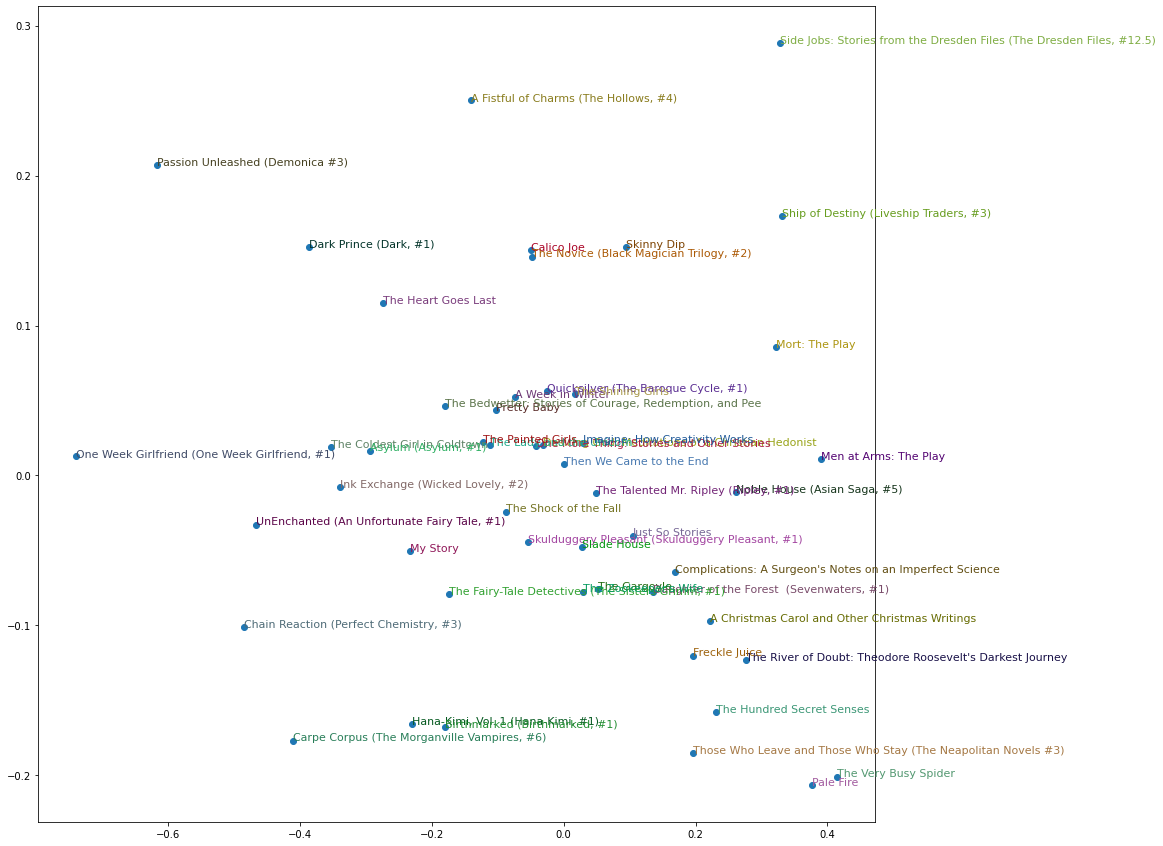

In [ ]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
  plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()